# This notebook is used to diagnose a bug causing Gradient wrong in GPU mode

In [1]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2.python.predictor.predictor_exporter as pe


from caffe2.python import core, model_helper, net_drawer, workspace, visualize, brew
from caffe2.proto import caffe2_pb2

if workspace.has_gpu_support:
    device_opts = core.DeviceOption(caffe2_pb2.CUDA, workspace.GetDefaultGPUID())
    print('Running in GPU mode on default device {}'.format(workspace.GetDefaultGPUID()))
else :
    device_opts = core.DeviceOption(caffe2_pb2.CPU, 0)
    print('Running in CPU mode')

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

Running in CPU mode
Necessities imported!


In [2]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/home/wangd/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/home/wangd/caffe2_notebooks/tutorial_files/tutorial_mnist


In [3]:
def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [4]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = brew.relu(model, fc3, fc3)
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    return pred

In [5]:
def AddSoftmax(model, pred):
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [6]:
def AddOnehot(model, label):
    label_int64 = model.Cast(label, None, to=core.DataType.INT64)
    with core.DeviceScope(device_opts):
        SIZE = model.param_init_net.ConstantFill([], 'SIZE', shape=[1,], value=10) # constant
    onehot = model.OneHot([label_int64, SIZE], 'onehot')
    onehot = model.StopGradient(onehot, onehot)
    return onehot

def AddTrainingOperators(model, pred, label):
    """Adds training operators to the model."""
    onehot = AddOnehot(model, label)
    softmax, xent = model.SoftmaxWithLoss([pred, onehot], ['softmax', 'xent'], label_prob=1)
    # compute the expected loss
    dist = model.SquaredL2Distance([softmax, onehot], 'dist')
    loss = model.AveragedLoss(dist, "loss")
    # track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([xent, loss])
    # do a simple stochastic gradient descent
    ITER = brew.iter(model, "iter")
    # set the learning rate schedule
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
    # ONE is a constant value that is used in the gradient update. We only need
    # to create it once, so it is explicitly placed in param_init_net.
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Now, for each parameter, we do the gradient updates.
    for param in model.params:
        # Note how we get the gradient of each parameter - ModelHelper keeps
        # track of that.
        param_grad = model.param_to_grad[param]
        # The update is a simple weighted sum: param = param + param_grad * LR
        model.WeightedSum([param, ONE, param_grad, LR], param)

In [7]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

In [8]:
arg_scope = {"order": "NCHW"}

with core.DeviceScope(device_opts):
    train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
    data, label = AddInput(
        train_model, batch_size=64,
        db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
        db_type='lmdb')
    pred = AddLeNetModel(train_model, data)
    AddTrainingOperators(train_model, pred, label)
    AddBookkeepingOperators(train_model)

# Testing model. We will set the batch size to 100, so that the testing
# pass is 100 iterations (10,000 images in total).
# For the testing model, we need the data input part, the main LeNetModel
# part, and an accuracy part. Note that init_params is set False because
# we will be using the parameters obtained from the train model.
with core.DeviceScope(device_opts):
    test_model = model_helper.ModelHelper(
        name="mnist_test", arg_scope=arg_scope, init_params=False)
    data, label = AddInput(
        test_model, batch_size=100,
        db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
        db_type='lmdb')
    pred = AddLeNetModel(test_model, data)
    softmax = AddSoftmax(test_model, pred)
    AddAccuracy(test_model, softmax, label)

# Deployment model. We simply need the main LeNetModel part.
with core.DeviceScope(device_opts):
    deploy_model = model_helper.ModelHelper(
        name="mnist_deploy", arg_scope=arg_scope, init_params=False)
    pred = AddLeNetModel(deploy_model, "data")
    softmax = AddSoftmax(deploy_model, pred)
# You may wonder what happens with the param_init_net part of the deploy_model.
# No, we will not use them, since during deployment time we will not randomly
# initialize the parameters, but load the parameters from the db.


In [9]:
# The parameter initialization network only needs to be run once.
workspace.RunNetOnce(train_model.param_init_net)
# creating the network
workspace.CreateNet(train_model.net, overwrite=True)
# set the number of iterations and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
loss1 = np.zeros(total_iters)
loss2 = np.zeros(total_iters)
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')
    loss1[i] = workspace.FetchBlob('xent')
    #loss2[i] = workspace.FetchBlob('loss2')


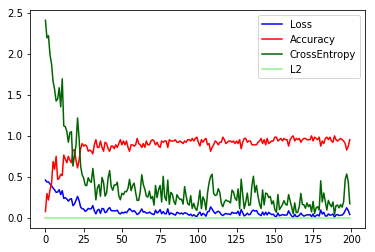

In [10]:
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.plot(loss1, 'darkgreen')
pyplot.plot(loss2, 'lightgreen')
pyplot.legend(('Loss', 'Accuracy', 'CrossEntropy', 'L2'), loc='upper right')

Now we can sample some of the data and predictions. 

test_accuracy: 0.951000


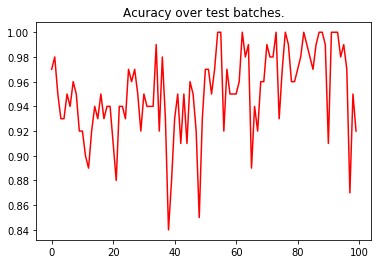

In [11]:
# run a test pass on the test net
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

In [19]:
workspace.FetchBlob('xent')

array(0.172334685921669, dtype=float32)